In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import importlib

import thalnet as TN
import tasks
from tasks import generate_trials

importlib.reload(TN)


<module 'thalnet' from '/Users/svasquez91/Dropbox/My_scripts_Dropbox/Models_Dropbox/ThalNet/thalnet.py'>

In [59]:
def get_default_hp(ruleset):
    '''Get a default hp.

    Useful for debugging.

    Returns:
        hp : a dictionary containing training hpuration
    '''
    num_ring = tasks.get_num_ring(ruleset)
    n_rule = tasks.get_num_rule(ruleset)

    n_eachring = 32
    n_input, n_output = 1+num_ring*n_eachring+n_rule, n_eachring+1
    hp = {
            # batch size for training
            'batch_size_train': 64,
            # batch_size for testing
            'batch_size_test': 512,
            # input type: normal, multi
            'in_type': 'normal',
            # Type of RNNs: LeakyRNN, LeakyGRU, EILeakyGRU, GRU, LSTM
            'rnn_type': 'LeakyRNN',
            # whether rule and stimulus inputs are represented separately
            'use_separate_input': False,
            # Type of loss functions
            'loss_type': 'lsq',
            # Optimizer
            'optimizer': 'adam',
            # Type of activation runctions, relu, softplus, tanh, elu
            'activation': 'relu',
            # Time constant (ms)
            'tau': 100,
            # discretization time step (ms)
            'dt': 20,
            # discretization time step/time constant
            'alpha': 0.2,
            # recurrent noise
            'sigma_rec': 0.05,
            # input noise
            'sigma_x': 0.01,
            # leaky_rec weight initialization, diag, randortho, randgauss
            'w_rec_init': 'randortho',
            # a default weak regularization prevents instability
            'l1_h': 0,
            # l2 regularization on activity
            'l2_h': 0,
            # l2 regularization on weight
            'l1_weight': 0,
            # l2 regularization on weight
            'l2_weight': 0,
            # l2 regularization on deviation from initialization
            'l2_weight_init': 0,
            # proportion of weights to train, None or float between (0, 1)
            'p_weight_train': None,
            # Stopping performance
            'target_perf': 0.9,
            # number of units each ring
            'n_eachring': n_eachring,
            # number of rings
            'num_ring': num_ring,
            # number of rules
            'n_rule': n_rule,
            # first input index for rule units
            'rule_start': 1+num_ring*n_eachring,
            # number of input units
            'n_input': n_input,
            # number of output units
            'n_output': n_output,
            # number of modules
            'n_modules': num_ring + 2,
            # number of recurrent units per ring
            'n_rnn': 500,
            # number of recurrent units for context and go inputs
            'n_rnn_contexts': 32,
            # number of dense units for output layers of rnn modules
            'n_dense_CT': 16,
            # number of input units
            'ruleset': ruleset,
            # name to save
            'save_name': 'test',
            # learning rate
            'learning_rate': 0.001,
            # intelligent synapses parameters, tuple (c, ksi)
            'c_intsyn': 0,
            'ksi_intsyn': 0,
            }

    return hp


ruleset = 'ctx_multi_sensory_delay'
hp = get_default_hp(ruleset)

seed = 42
hp['seed'] = seed
hp['rng'] = np.random.RandomState(seed)

# Rules to train and test. Rules in a set are trained together

hp['rule_trains'] = tasks.rules_dict[ruleset]
hp['rules'] = hp['rule_trains']

# Assign probabilities for rule_trains.
rule_prob_map = dict()

# Turn into rule_trains format
hp['rule_probs'] = None
if hasattr(hp['rule_trains'], '__iter__'):
    # Set default as 1.
    rule_prob = np.array(
            [rule_prob_map.get(r, 1.) for r in hp['rule_trains']])
    hp['rule_probs'] = list(rule_prob/np.sum(rule_prob))

In [60]:
tf.keras.backend.clear_session()

In [61]:
inputs = tf.keras.Input((None, hp['n_input']), name='inputs')
rnn = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn')(inputs)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_output']), name='outputs')(rnn)

In [62]:
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [63]:
weights = model.get_weights()

(68, 128)
(128, 128)
(128,)
(128, 33)
(33,)


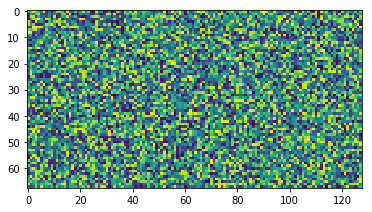

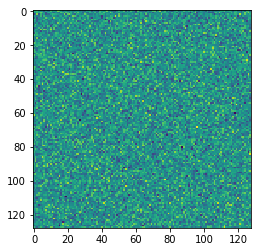

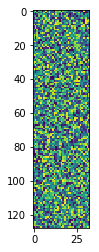

In [15]:
for w in weights:
    print(w.shape)
    if len(w.shape)>1:
        plt.figure()
        plt.imshow(w)

In [64]:
def reduce_weight_matrix(weights, pre_node_indexes='all', post_node_indexes='all', keep_recurrency=False):
    if pre_node_indexes == 'all':
        pre_node_indexes = range(weights.shape[0])
    if post_node_indexes == 'all':
        post_node_indexes = range(weights.shape[1])
        
    weights_to_zero = np.setdiff1d(range(weights[0].shape[0]),post_node_indexes)
    
    if keep_recurrency:
        if weights.shape[0] == weights.shape[1]:
            weights_to_zero = np.setdiff1d(weights_to_zero,pre_node_indexes)
        else:
            print('Weight matrix is not squared!')
        
    if len(weights_to_zero.shape):
        weights[np.ix_(pre_node_indexes,weights_to_zero)] = 0
        
    return weights

In [68]:
#n_input = 1+num_ring*n_eachring+n_rule
input_to_rnn_w = weights[0]

# go and rule inputs to rnn
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=[0],post_node_indexes=range(0,100))
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(hp['n_input']-hp['n_rule'],hp['n_input']),post_node_indexes=range(0,100))

# modalities to rnn
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(1+0*hp['n_eachring'],1+1*hp['n_eachring']),post_node_indexes=range(100,200))
input_to_rnn_w = reduce_weight_matrix(input_to_rnn_w,pre_node_indexes=range(1+1*hp['n_eachring'],1+2*hp['n_eachring']),post_node_indexes=range(200,300))

In [70]:
#n_rnn = n_rnn_go_contex + n_rnn_mod1 + n_rnn_mod2 + n_rnn_motor + n_rnn_thalamus
rnn_w = weights[1]

# cortex modules to thalamus
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(0,100),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #go and rule module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(100,200),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #mod 1 module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(200,300),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #mod 1 module
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(300,400),post_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']), keep_recurrency=True) #motor module

# thalamus module to cortex
rnn_w = reduce_weight_matrix(rnn_w,pre_node_indexes=range(hp['n_rnn']-100,hp['n_rnn']),post_node_indexes=range(0,hp['n_rnn']-100), keep_recurrency=False) #thalamus module

In [83]:
#n_output = n_eachring+1
rnn_to_output_w = weights[3]

# rnn to outputs
rnn_to_output_w = reduce_weight_matrix(rnn_to_output_w.T,pre_node_indexes='all',post_node_indexes=range(300,400)).T

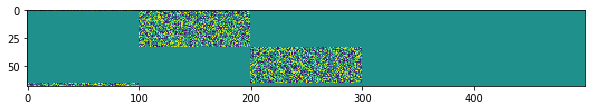

In [73]:
plt.figure(figsize=[20,20])
plt.imshow(input_to_rnn_w)
#plt.plot(input_to_rnn_w[0,:])

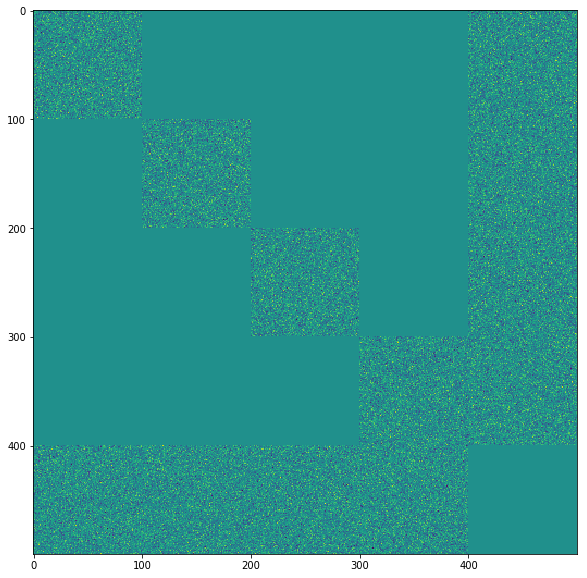

In [74]:
plt.figure(figsize=[10,10])
plt.imshow(rnn_w)
#plt.plot(rnn_w[0,:])

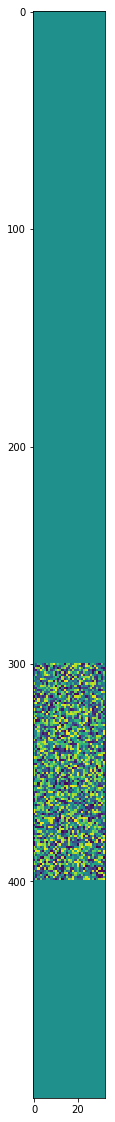

In [84]:
plt.figure(figsize=[20,20])
plt.imshow(rnn_to_output_w)
#plt.plot(rnn_to_output_w[0,:])

In [25]:
input_mod1 = tf.keras.Input((None, hp['n_eachring']), name='input_mod1')
input_mod2 = tf.keras.Input((None, hp['n_eachring']), name='input_mod2')
input_context_and_go = tf.keras.Input((None, hp['n_rule']+1), name='input_context_and_go')

rnn_mod1 = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_mod1')(input_mod1)
dense_mod1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), name='dense_mod1')(rnn_mod1)

rnn_mod2 = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_mod2')(input_mod2)
dense_mod2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), name='dense_mod2')(rnn_mod2)

rnn_context_and_go = tf.keras.layers.SimpleRNN(hp['n_rnn_contexts'], 
                                               return_sequences=True, 
                                               name='rnn_context_and_go')(input_context_and_go)
dense_context_and_go = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_dense_CT']), 
                                                       name='dense_context_and_go')(rnn_context_and_go)

thal_hub = tf.keras.layers.Concatenate(name='thalamic_hub')([dense_mod1,dense_mod2,dense_context_and_go])

rnn_motor = tf.keras.layers.SimpleRNN(hp['n_rnn'], return_sequences=True, name='rnn_motor')(thal_hub)

output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hp['n_output']), name='outputs')(rnn_motor)

TC_model = tf.keras.models.Model(inputs=[input_mod1, input_mod2, input_context_and_go], outputs=output)

TC_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [59]:
max_steps=1e6
step = 0
while step * hp['batch_size_train'] <= max_steps:
    try:
        # Training
        rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])
        # Generate a random batch of trials.
        # Each batch has the same trial length
        trial = generate_trials(
            rule_train_now, hp, 'random',
            batch_size=hp['batch_size_train'])

        all_inputs = np.transpose(trial.x,(1,0,2))
        inputs_mod1 = all_inputs[:,:,1:(1+hp['n_eachring'])]
        inputs_mod2 = all_inputs[:,:,(1+hp['n_eachring']):(1+2*hp['n_eachring'])]
        inputs_context_and_go = np.concatenate([all_inputs[:,:,:1],all_inputs[:,:,(1+2*hp['n_eachring']):]],axis=2)
        
        targets = np.transpose(trial.y,(1,0,2))
        history = TC_model.fit([inputs_mod1,inputs_mod2,inputs_context_and_go], targets, epochs=20)

        # Generating feed_dict.
        # feed_dict = tools.gen_feed_dict(model, trial, hp)
        # sess.run(model.train_step, feed_dict=feed_dict)

        step += 1

    except KeyboardInterrupt:
        print("Optimization interrupted by user")
        break

print("Optimization finished!")


Train on 64 samples
Epoch 1/20
64/64 [==============================] - 2s 27ms/sample - loss: 0.0172 - accuracy: 0.7510
Epoch 2/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0169 - accuracy: 0.7519
Epoch 3/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0168 - accuracy: 0.7513
Epoch 4/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0166 - accuracy: 0.7489
Epoch 5/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0163 - accuracy: 0.7503
Epoch 6/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0163 - accuracy: 0.7494
Epoch 7/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0161 - accuracy: 0.7490
Epoch 8/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0160 - accuracy: 0.7500
Epoch 9/20
64/64 [==============================] - 0s 2ms/sample - loss: 0.0160 - accuracy: 0.7519
Epoch 10/20
64/64 [==============================] - 0s 3ms/sample - loss: 0.01

In [68]:
import time

model.save("./saved_models/my_TC_model_" + time.strftime("%Y%m%d-%H%M%S") + ".h5")
#model.save_weights('./checkpoints/my_checkpoint')

----

In [14]:
tdim = None
batch_size = hp['batch_size_train']

inputs_sizes = [[batch_size,tdim,hp['n_eachring']+1], #[Batch, Time, Num_units]
                [batch_size,tdim,hp['n_eachring']],
                [batch_size,tdim,hp['n_rule']],
                None]

outputs_sizes = [None,
                 None,
                 None,
                 hp['n_output']] #[Num_units]

total_input_size = np.sum([sz[2] for sz in inputs_sizes if sz is not None])
total_output_size = np.sum([sz for sz in outputs_sizes if sz is not None])

rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])

trial = generate_trials(
    rule_train_now, hp, 'random',
    batch_size=hp['batch_size_train'])

inputs = np.transpose(trial.x,(1,0,2))
targets = np.transpose(trial.y,(1,0,2))

In [ ]:
importlib.reload(TN)
tf.keras.backend.clear_session()

thalnet_network = TN.ThalNet(TN.SimpleRNNCell, inputs_sizes, outputs_sizes, n_modules=hp['n_modules'])

# thalnet_network = tf.keras.models.Sequential([TN.ThalNet(TN.SimpleRNNCell, inputs_sizes, 
#                                                          outputs_sizes, n_modules=hp['n_modules'])])

                                                         

#print(inputs.shape)
outputs = thalnet_network(inputs)
print(outputs.shape)

In [73]:
thalnet_network.compile(loss="mse", optimizer="adam", run_eagerly=True)
history = thalnet_network.fit(trial.x, trial.y, epochs=1)

Train on 165 samples
165/165 [==============================] - 17s 101ms/sample - loss: 0.1174


In [ ]:
max_steps=1e2 #1e6
step = 0
while step * hp['batch_size_train'] <= max_steps:
    try:
        # Validation
        # if step % display_step == 0:
        #     log['trials'].append(step * hp['batch_size_train'])
        #     log['times'].append(time.time() - t_start)
        #     log = do_eval(sess, model, log, hp['rule_trains'])
        #     # if log['perf_avg'][-1] > model.hp['target_perf']:
        #     # check if minimum performance is above target
        #     if log['perf_min'][-1] > model.hp['target_perf']:
        #         print('Perf reached the target: {:0.2f}'.format(
        #             hp['target_perf']))
        #         break
        #
        #     if rich_output:
        #         display_rich_output(model, sess, step, log, model_dir)

        # Training
        rule_train_now = hp['rng'].choice(hp['rule_trains'],
                                          p=hp['rule_probs'])
        # Generate a random batch of trials.
        # Each batch has the same trial length
        trial = generate_trials(
            rule_train_now, hp, 'random',
            batch_size=hp['batch_size_train'])

        inputs = np.transpose(trial.x,(1,0,2))
        targets = np.transpose(trial.y,(1,0,2))
        history = thalnet_network.fit(inputs, targets, epochs=20)

        # Generating feed_dict.
        # feed_dict = tools.gen_feed_dict(model, trial, hp)
        # sess.run(model.train_step, feed_dict=feed_dict)

        step += 1

    except KeyboardInterrupt:
        print("Optimization interrupted by user")
        break

print("Optimization finished!")


In [1]:
# upgrade the .py files and copy all the other files to the outtree
!tf_upgrade_v2 \
    --intree v1_4/ \
    --outtree v2_0/ \
    --reportfile tree_report.txt

INFO line 59:17: Renamed 'tf.variable_scope' to 'tf.compat.v1.variable_scope'
ERROR line 31:15: Using member tf.contrib.layers.fully_connected in deprecated module tf.contrib. tf.contrib.layers.fully_connected cannot be converted automatically. tf.contrib will not be distributed with TensorFlow 2.0, please consider an alternative in non-contrib TensorFlow, a community-maintained repository such as tensorflow/addons, or fork the required code.
INFO line 40:15: Added keywords to args of function 'tf.reduce_mean'
INFO line 40:30: Changing labels arg of tf.nn.softmax_cross_entropy_with_logits to tf.stop_gradient(labels). Please check this transformation.

INFO line 44:27: Added keywords to args of function 'tf.argmax'
INFO line 44:59: Added keywords to args of function 'tf.argmax'
INFO line 45:15: Added keywords to args of function 'tf.reduce_mean'
INFO line 49:15: Renamed 'tf.train.AdamOptimizer' to 'tf.compat.v1.train.AdamOptimizer'
INFO line 53:42: Renamed 'tf.get_collection' to 'tf.com